In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import time
import copy
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)

    my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = data.DataLoader(my_dataset) # create your dataloader
    return my_dataloader
    
def T_scaling(logits, temperature):
  return torch.div(logits, temperature)

def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    #temperature = nn.Parameter(torch.ones(1) * temp_constant)
    #temperature = temperature.unsqueeze(1).expand(logits.size(0), logits.size(1)).cuda()
    #return F.cross_entropy(T_scaling(logits, temperature), y_batch).mean()
    return F.cross_entropy(logits, y_batch).mean()

In [2]:
transform = transforms.ToTensor()
batch_size=100

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.FashionMNIST('fashion-10', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('fashion-10', download=True, train=False, transform=transform)
print(trainset[0][0].shape)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valset, testset = torch.utils.data.random_split(testset, [100, 9900])
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
print(len(valset))
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)


Extracting fashion-10/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion-10/FashionMNIST/raw



Extracting fashion-10/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion-10/FashionMNIST/raw



Extracting fashion-10/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion-10/FashionMNIST/raw



Extracting fashion-10/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion-10/FashionMNIST/raw
Processing...
Done!
torch.Size([1, 28, 28])
100


In [16]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. #* math.exp(-x * 0.1)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)
    return lr_lambda

In [17]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=480, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits#, probs

In [40]:
import time
import copy

temps = [0.1, 2., 3.]
torch.cuda.empty_cache()
#resnet18 = ResNet(BasicBlock, [2,2,2,2]) #models.resnet18(num_classes=10, pretrained=False)
resnet18 = LeNet5(10)
cnt = 0
for el in resnet18.parameters():
  cnt += 1
print(cnt)
resnet18 = resnet18.cuda()

num_epochs = 71
start_lr = 0.01
end_lr = 0.1
factor = 10
#temperature = nn.Parameter(torch.ones(1).cuda())
#opt = torch.optim.LBFGS(list(resnet18.parameters()) + [temperature], lr=end_lr, max_iter=10000, line_search_fn='strong_wolfe')
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)


step_size = 4*len(trainset) / batch_size
print(step_size)
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

models_list = []
weight_list = []
loss_list = []
train_loss_list = []

train_loss = []
val_accuracy = []
losses = []
accs = []

lr_find_loss = []
learning_rates = []

it = 0

smoothing = 0.5
small_flag = False
lrs = []

for epoch in range(num_epochs):
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        num_loss = loss.data.cpu().numpy()
        train_loss.append(num_loss)
        
        scheduler.step()
        opt.zero_grad()

        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        learning_rates.append(lr_step)
        #print(lr_step)
        if lr_step <= 0.00103:
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(10.)
            val_loss = 0.
            for (X_batch, y_batch) in valloader:
                val_loss += compute_loss(X_batch, y_batch)
            val_loss = val_loss.detach().cpu().numpy() * batch_size/ len(testloader.dataset)
            #print('min', val_loss)
            loss_list.append(val_loss)
            train_loss_list.append(num_loss)
        elif lr_step <= 0.00502 and lr_step > 0.00499 and lr_step > learning_rates[-2]:
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(1.)
            val_loss = 0.
            for (X_batch, y_batch) in valloader:
                val_loss += compute_loss(X_batch, y_batch)
            val_loss = val_loss.detach().cpu().numpy() * batch_size/ len(testloader.dataset)
            #print('not', val_loss)
            loss_list.append(val_loss)
            train_loss_list.append(num_loss)
        if len(models_list) > 25:
          models_list = models_list[-25:]
        it += 1
              

        resnet18.train(False)
    for (X_batch, y_batch) in testloader:
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
    
    accs.append(np.mean(val_accuracy[-len(testset) // batch_size :]))
    cur_loss = np.mean(train_loss[-len(trainset) // batch_size :])


        
    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

10
2400.0
Epoch 1 of 71 took 10.716s
  training loss (in-iteration): 	0.679620
  validation accuracy: 			79.73 %
Epoch 11 of 71 took 10.619s
  training loss (in-iteration): 	0.403603
  validation accuracy: 			82.44 %
Epoch 21 of 71 took 10.579s
  training loss (in-iteration): 	0.468544
  validation accuracy: 			81.78 %
Epoch 31 of 71 took 10.741s
  training loss (in-iteration): 	0.387007
  validation accuracy: 			85.23 %
Epoch 41 of 71 took 10.927s
  training loss (in-iteration): 	0.340147
  validation accuracy: 			86.19 %
Epoch 51 of 71 took 10.567s
  training loss (in-iteration): 	0.398594
  validation accuracy: 			83.64 %
Epoch 61 of 71 took 10.648s
  training loss (in-iteration): 	0.444077
  validation accuracy: 			83.64 %
Epoch 71 of 71 took 10.630s
  training loss (in-iteration): 	0.385904
  validation accuracy: 			84.88 %


In [41]:
torch.save(resnet18.state_dict(), 'lenet_small_lr.pt')
from google.colab import files
files.download('lenet_small_lr.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
original_loss_list = loss_list
original_train_loss_list = train_loss_list

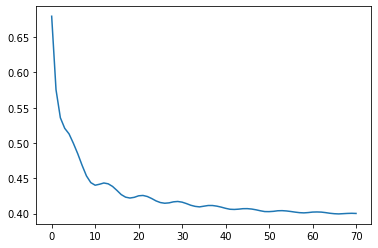

In [43]:
plt.plot(np.array(list(range(len(losses)))), losses)
#plt.plot(list(range(len(learning_rates))), (np.array(learning_rates) * 10))
plt.show()

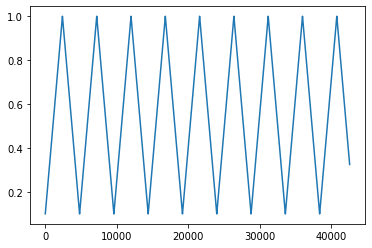

In [44]:
plt.plot(list(range(len(learning_rates))), (np.array(learning_rates) * 100))
plt.show()

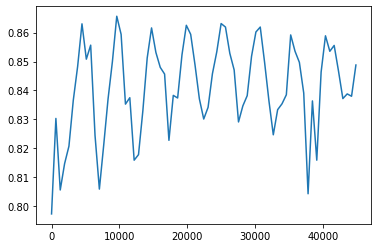

In [45]:
plt.plot(np.array(list(range(len(accs)))) * 640, accs)
#plt.plot(list(range(len(learning_rates))), (np.array(learning_rates) * 10))
plt.show()

In [46]:
def weigheted_most_common(predictions, weights):
    new_predictions = {}
    for i in range(len(predictions)):
        if predictions[i] in new_predictions:
            new_predictions[predictions[i]] = new_predictions[predictions[i]] + weights[i]
        else:
            new_predictions[predictions[i]] = weights[i]
    top = list(sorted(new_predictions.items(), key=lambda item: item[1], reverse=True))
    return top[0][0]
from collections import Counter
import numpy as np
def ensemble_predictions(members, loader, weights):
    accs = []
    for (X_batch, y_batch) in loader:
        yhats = []
        for model in members:
            y_batch = y_batch.cuda()
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            yhats.append(y_pred.cpu().numpy())
        yhats = np.array(yhats)
        maxs = []
        for i in range(yhats.shape[1]):
            cur_max = weigheted_most_common(yhats[:, i], weights)
            maxs.append(cur_max)
        # sum across ensemble members
        maxs = np.array(maxs)
        # argmax across classes
        accs.append(np.mean((y_batch.cpu().numpy() == maxs)))
    accs = np.array(accs)
    return accs, np.mean(accs)

In [47]:
temps = [0.1, 0.3, 0.5, 0.8, 1.1, 1.5,]
#original_loss_list = loss_list
ens_accs = []
print(len(models_list))
for t in temps:
    temp_constant = t
    loss_list = np.array(original_loss_list[-len(models_list):])
    #weight_list = weight_list[-len(models_list):]
    #print(loss_list)
    for i in range(loss_list.shape[0]):
        loss_list[i] = np.exp(loss_list[i] / temp_constant)
    weights = loss_list#np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    #print(weights)
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25
0.1 Ensemble accuracy =  86.2 %
0.3 Ensemble accuracy =  86.2 %
0.5 Ensemble accuracy =  86.2 %
0.8 Ensemble accuracy =  86.2 %
1.1 Ensemble accuracy =  86.2 %
1.5 Ensemble accuracy =  86.2 %


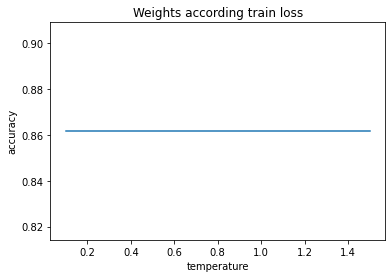

In [48]:
plt.plot(temps, ens_accs)
plt.title('Weights according train loss')
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

In [49]:
temps = [0.1, 0.3, 0.5, 0.8, 1.1, 1.5,]
#original_loss_list = loss_list
ens_accs = []
print(len(models_list))
for t in temps:
    temp_constant = t
    loss_list = np.array(original_train_loss_list[-len(models_list):])
    #weight_list = weight_list[-len(models_list):]
    #print(loss_list)
    for i in range(loss_list.shape[0]):
        loss_list[i] = np.exp(loss_list[i] / temp_constant)
    weights = loss_list#np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    #print(weights)
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25
0.1 Ensemble accuracy =  86.5 %
0.3 Ensemble accuracy =  86.2 %
0.5 Ensemble accuracy =  86.2 %
0.8 Ensemble accuracy =  86.2 %
1.1 Ensemble accuracy =  86.2 %
1.5 Ensemble accuracy =  86.2 %


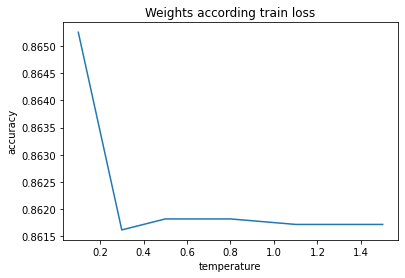

In [50]:
plt.plot(temps, ens_accs)
plt.title('Weights according train loss')
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

In [51]:
print(weight_list)

[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0

In [52]:
temps = [0.1, 0.3, 0.5, 0.8, 1.1, 1.5,]
#original_loss_list = loss_list
ens_accs = []
print(len(models_list))
for t in temps:
    #temp_constant = t
    #loss_list = np.array(original_train_loss_list[-len(models_list):])
    weight_list = weight_list[-len(models_list):]
    #print(loss_list)
    #for i in range(loss_list.shape[0]):
    #    loss_list[i] = np.exp(loss_list[i] / temp_constant)
    #weights = loss_list #np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    weights = []
    for w in weight_list:
        if w > 2.0:
            weights.append(w * t)
        else:
            weights.append(w)
    #print(weights)
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25
0.1 Ensemble accuracy =  86.2 %
0.3 Ensemble accuracy =  86.0 %
0.5 Ensemble accuracy =  85.9 %
0.8 Ensemble accuracy =  85.9 %
1.1 Ensemble accuracy =  85.9 %
1.5 Ensemble accuracy =  85.9 %


In [53]:
for model in models_list:
  accuracy = []
  for (X_batch, y_batch) in testloader:
          y_batch = y_batch.cuda()
          logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
          y_pred = logits.max(1)[1].data
          accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
  print(np.array(accuracy).mean() * 100, '%')

85.19191919191921 %
85.22222222222223 %
85.77777777777776 %
85.78787878787878 %
85.74747474747475 %
85.93939393939394 %
85.94949494949496 %
86.0 %
85.87878787878788 %
85.88888888888889 %
85.84848484848484 %
85.90909090909092 %
85.89898989898991 %
85.93939393939394 %
85.9191919191919 %
85.87878787878788 %
85.85858585858584 %
85.22222222222221 %
85.12121212121212 %
84.85858585858584 %
84.91919191919192 %
84.85858585858587 %
84.73737373737373 %
84.7878787878788 %
85.15151515151514 %


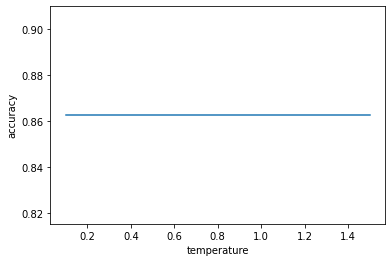

In [15]:
small_ens_accs = ens_accs
plt.plot(temps, small_ens_accs)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

In [ ]:
weights = np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
print(round(mean_accs, 3) * 100, '%')

93.8 %


In [ ]:
import time
import copy

temps = [6., 10.]
#ens_accs = []

for t in temps:
    torch.cuda.empty_cache()
    print('Experiment for t = {}'.format(t))
    temp_constant = t
    resnet18 = ResNet(BasicBlock, [2,2,2,2]) #models.resnet18(num_classes=10, pretrained=False)
    resnet18 = resnet18.cuda()

    num_epochs = 21
    start_lr = 0.01
    end_lr = 0.1
    factor = 10
    temperature = nn.Parameter(torch.ones(1).cuda())
    #opt = torch.optim.LBFGS(list(resnet18.parameters()) + [temperature], lr=end_lr, max_iter=10000, line_search_fn='strong_wolfe')
    opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)


    step_size = 1*len(trainset) / batch_size
    print(step_size)
    clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

    models_list = []
    weight_list = []
    loss_list = []

    train_loss = []
    val_accuracy = []
    losses = []
    accs = []

    lr_find_loss = []
    learning_rates = []

    it = 0

    smoothing = 0.5
    small_flag = False
    lrs = []

    for epoch in range(num_epochs):
        start_time = time.time()
        resnet18.train(True)
        for (X_batch, y_batch) in trainloader:
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            #print(loss.data.cpu().numpy())
            train_loss.append(loss.data.cpu().numpy())
            
            scheduler.step()
            opt.zero_grad()

            lr_step = opt.state_dict()["param_groups"][0]["lr"]
            learning_rates.append(lr_step)
            #lr_find_loss.append(loss)
            if lr_step <= 0.00103:
                #print('add minimun')
                models_list.append(copy.deepcopy(resnet18))
                weight_list.append(10.)
                loss_list.append(loss)
            elif lr_step <= 0.00502 and lr_step > 0.00499:
                #print('add not minimum')
                models_list.append(copy.deepcopy(resnet18))
                weight_list.append(1.)
                loss_list.append(loss)
            if len(models_list) > 25:
              models_list = models_list[-25:]
            it += 1
            

        resnet18.train(False)
        for (X_batch, y_batch) in testloader:
            y_batch = y_batch.cuda()
            logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
        
        accs.append(np.mean(val_accuracy[-len(testset) // batch_size :]))
        cur_loss = np.mean(train_loss[-len(trainset) // batch_size :])


        
        if epoch % 10 == 0:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(
                np.mean(train_loss[-len(trainset) // batch_size :])))
            print("  validation accuracy: \t\t\t{:.2f} %".format(
                np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
        losses.append(np.array(train_loss).mean())
    loss_list = np.array(loss_list[-len(models_list):])
    #weight_list = weight_list[-len(models_list):]
    for i in range(loss_list.shape[0]):
        loss_list[i] = loss_list[i].detach().cpu().numpy()
    weights = np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print('Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

Experiment for t = 6.0


RuntimeError: ignored

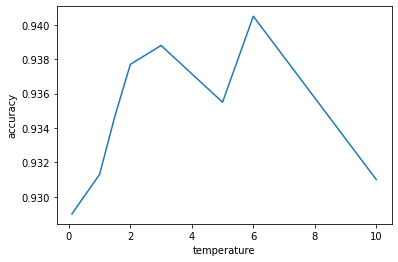

In [ ]:
plt.plot([0.1, 1., 1.5, 2., 3., 5., 6., 10.], ens_accs)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()